In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0,"../")
import optax
from optax.schedules import warmup_cosine_decay_schedule
from scipy.stats import gaussian_kde

from src.kernel import VFTSGaussKernel,TSGaussGaussKernel
from src.loss import SumVarifoldLoss
from src.lddmm import Shooting,Flowing,batch_one_to_many_registration
from src.utils import batch_dataset


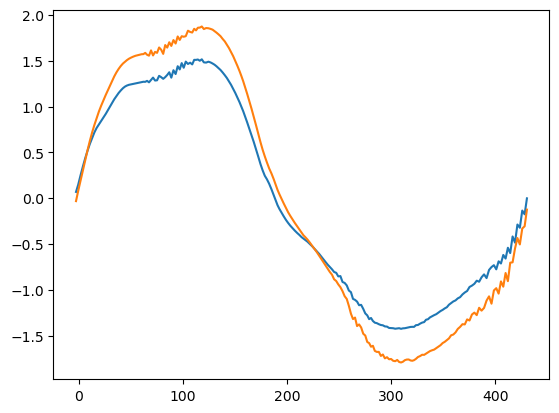

In [2]:
np.random.seed(0)

y =pd.read_csv("./dataset/y_600.csv",index_col=0)
X = np.load("./dataset/X_600.npy")
X_mask = np.load("./dataset/X_600_mask.npy")
idxs = np.load("./results/ts-lddmm_exp_1/idxs.npy")
X,X_mask = X[idxs],X_mask[idxs]
X,X_mask = X[:,::2,:],X_mask[:,::2,:]
y = y.iloc[idxs]



p0s = np.load("./results/ts-lddmm_exp_1/p0s.npy")
q0 = np.load("./results/ts-lddmm_exp_1/q0.npy")
q0_mask = np.load("./results/ts-lddmm_exp_1/q0_mask.npy")
p0s = p0s.reshape(-1,p0s.shape[2],p0s.shape[3])
plt.plot(q0[q0_mask.squeeze(),0],q0[q0_mask.squeeze(),1])
plt.plot(q0[q0_mask.squeeze(),0],q0[q0_mask.squeeze(),2])

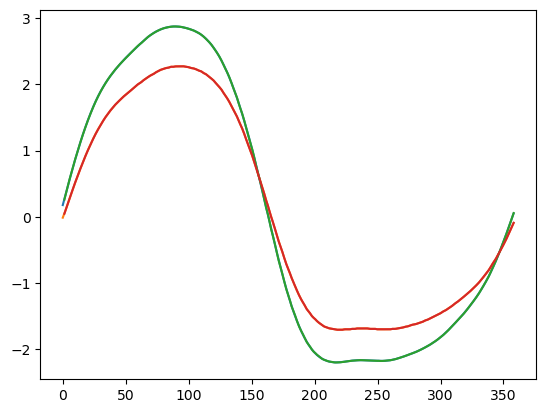

In [3]:
Kv = VFTSGaussKernel(1,0.1,150,1,2)
Kl1 = TSGaussGaussKernel(5,2,5,1)
Kl2 = TSGaussGaussKernel(2,1,2,0.6)
Kl3 = TSGaussGaussKernel(1,0.6,1,0.6)
Kls=[Kl1,Kl2,Kl3]
dataloss = SumVarifoldLoss(Kls)

shoot = Shooting(Kv)
flow = Flowing(Kv)

idx = -10
p,q = shoot(p0s[idx],q0,q0_mask)
x = X[idx][X_mask[idx].squeeze()]
qp = q[q0_mask.squeeze()]
plt.plot(x[:,0],x[:,1],)
plt.plot(x[:,0],x[:,2])
plt.plot(qp[:,0],qp[:,1])
plt.plot(qp[:,0],qp[:,2])

filename    20161214_wt#31_physo0,33_i5_e60_ep30.EDF
genotype                                          wt
before                                             Y
start                                        2094321
end                                          2094681
Name: 690, dtype: object


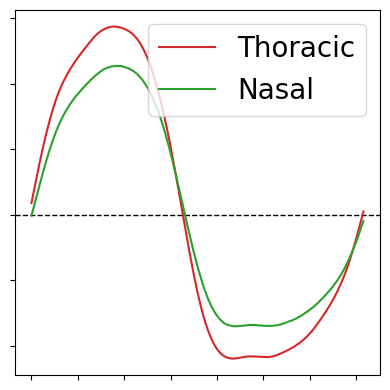

In [4]:
df = y.reset_index(drop=True)
idx = 690
print(df.loc[idx])
q = X[idx][X_mask[idx].squeeze()]
fig,ax = plt.subplots(nrows=1,ncols=1, figsize = (4,4))


ax.plot(q[:,0],q[:,1],color="tab:red",label="Thoracic")
ax.plot(q[:,0],q[:,2],color="tab:green",label="Nasal")
ax.axhline(0,color="black",linewidth=1,linestyle="--",zorder=0)
ax.legend(fontsize=20,loc=1)

ax.set_xticklabels([])
ax.set_yticklabels([])
fig.tight_layout()
fig.savefig("./figures/ts-lddmm_exp_1_wt.jpeg",format="jpeg")

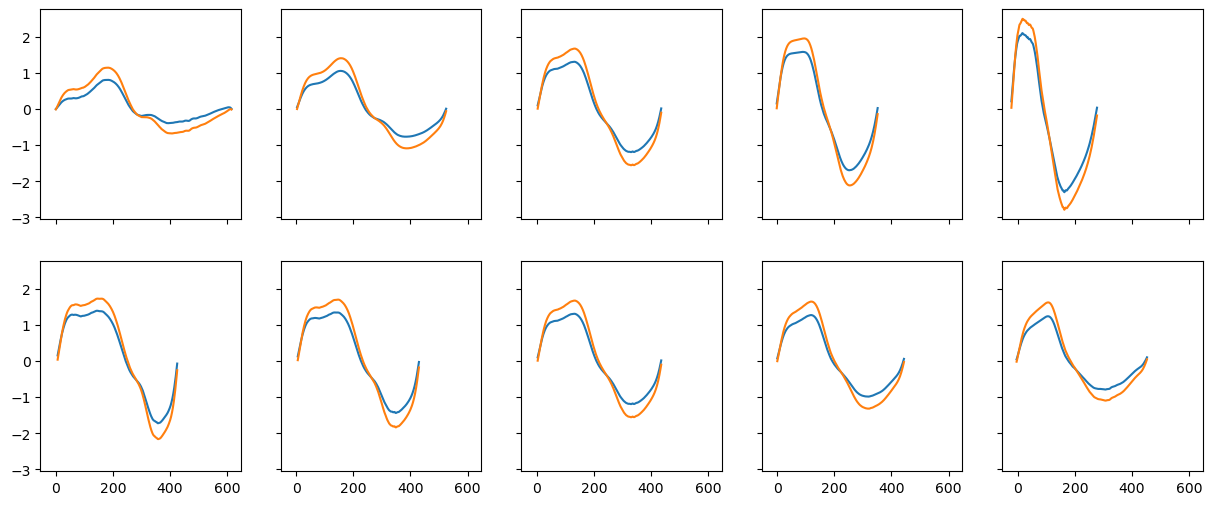

In [9]:
from src.statistic import MomentaPCA
n_comp,n_disp = 2,5
mpca = MomentaPCA(n_comp,False,"cov")
mpca.fit(Kv,p0s,q0,q0_mask)

p0_bar = mpca.m_ps_
plot_mask = np.where(q0_mask==True)[0]
k = 1
shoot = Shooting(Kv)
p0_b = mpca.m_ps_
fig,axs = plt.subplots(n_comp,n_disp,figsize = (n_disp*3,n_comp*3),sharex=True,sharey=True)
for pca_index in range(n_comp):
    sigma_pca = mpca.p_std_[pca_index]
    for j,alpha in enumerate(np.linspace(-2*sigma_pca , 2*sigma_pca, n_disp)):
        p0_mode = p0_b + alpha * mpca.p_pc_[pca_index]
        _,q = shoot(p0_mode,q0,q0_mask)
        plot_q = q[plot_mask].T
        axs[pca_index,j].plot(plot_q[0],plot_q[1])
        axs[pca_index,j].plot(plot_q[0],plot_q[2])

/tmp/ipykernel_1606681/4197659364.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11.442275    6.13283333  3.28498333 10.71610833  0.59155833 10.04145833
  4.060775    8.412425    7.75518333  7.03854167 13.31669167  5.162775
  7.080075    5.52525     6.26725833  3.528825    7.86451667  9.077975
  4.524775    1.68323333 12.11700833  6.48305833  2.2289      0.63905833
 12.49041667  2.11320833  4.30318333  9.91180833  9.61264167  2.634675
 13.61921667  8.31091667  2.64438333 12.53698333 13.2605      5.91893333
  1.79654167  8.30736667  6.08608333  9.14410833 11.16398333  0.27348333
 14.01114167  4.27899167  1.02571667  6.05201667 11.46274167 14.19718333
 11.99968333 10.88709167 14.25390833  0.80569167  6.03240833 12.758525
  5.50325833 11.95425833 12.65255833  3.816025   11.47029167 10.23803333
 10.29786667 15.40724167 14.341325    9.78260833  8.553275    3.80879167
  6.1992     18.92493333  5.614125    1.597875

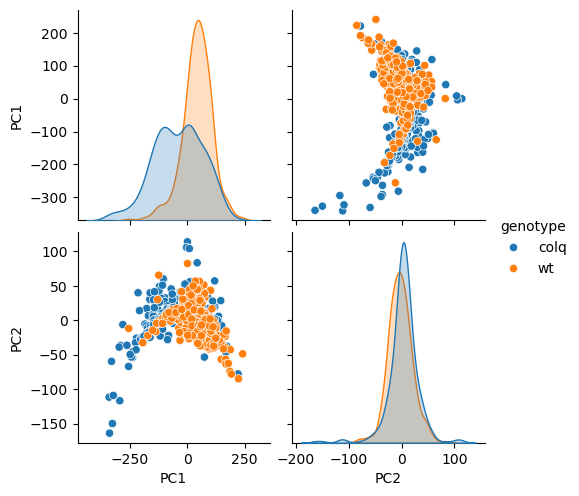

In [13]:
df = y.copy()
filenames = df.filename.unique()

def create_mapping(filenames): 
    dct = {}
    count_colq = 1
    count_wt = 1
    for filename in filenames: 
        if "colq" in filename: 
            dct[filename] = f"colq_{count_colq}"
            count_colq +=1
        elif "wt" in filename: 
            dct[filename] = f"wt_{count_wt}"
            count_wt +=1
    return dct

mapping_dct = create_mapping(filenames)
df["mouse_id"] = df.filename.apply(lambda x :mapping_dct[x])



df[[f"PC{i+1}" for i in range(n_comp)]] = mpca.p_score_
tdf = df[["start","before"]]
max_before = tdf[tdf.before == "Y"].start.max()
tdf.loc[tdf.before == "N","start"] = tdf[tdf.before == "N"].start.copy().values + max_before
tdf.loc[:,"start"] /= (2000.*60.)
df["time"] = tdf.start
sns.pairplot(df,hue = "genotype",vars=[f"PC{i+1}" for i in range(n_comp)])

In [15]:
tdf = df.copy()
filenames = tdf.filename.unique()

q_lst = []
q_mask_lst = []

for filename in filenames: 
    q = np.load("./results/ts-lddmm_exp_1/"+filename[:-4]+"_q0.npy")
    q_lst.append(q)
    q_mask = np.load("./results/ts-lddmm_exp_1/"+filename[:-4]+"_q0_mask.npy")
    q_mask_lst.append(q_mask)
        
qs = np.array(q_lst)
qs_mask = np.array(q_mask_lst)

In [18]:
schedule = warmup_cosine_decay_schedule(0,0.1,80,800,0)
optimizer = optax.adabelief(schedule)
bqs,bqs_mask = batch_dataset(qs,1,qs_mask)
bps,q0,q0_mask = batch_one_to_many_registration(q0,q0_mask,bqs,bqs_mask,Kv,dataloss,optimizer=optimizer,gamma_loss=1e-3,niter=400)

iteration:  1 / 400  -- loss:  3881.52
iteration:  10 / 400  -- loss:  3640.61
iteration:  20 / 400  -- loss:  3079.57
iteration:  30 / 400  -- loss:  2567.01
iteration:  40 / 400  -- loss:  2018.65
iteration:  50 / 400  -- loss:  1385.15
iteration:  60 / 400  -- loss:  1014.81
iteration:  70 / 400  -- loss:  899.21
iteration:  80 / 400  -- loss:  883.21
iteration:  90 / 400  -- loss:  773.66
iteration:  100 / 400  -- loss:  853.28
iteration:  110 / 400  -- loss:  773.24
iteration:  120 / 400  -- loss:  734.32
iteration:  130 / 400  -- loss:  709.85
iteration:  140 / 400  -- loss:  697.57
iteration:  150 / 400  -- loss:  622.34
iteration:  160 / 400  -- loss:  635.62
iteration:  170 / 400  -- loss:  592.64
iteration:  180 / 400  -- loss:  665.52
iteration:  190 / 400  -- loss:  657.44
iteration:  200 / 400  -- loss:  630.09
iteration:  210 / 400  -- loss:  634.58
iteration:  220 / 400  -- loss:  617.40
iteration:  230 / 400  -- loss:  567.78
iteration:  240 / 400  -- loss:  538.09
iter

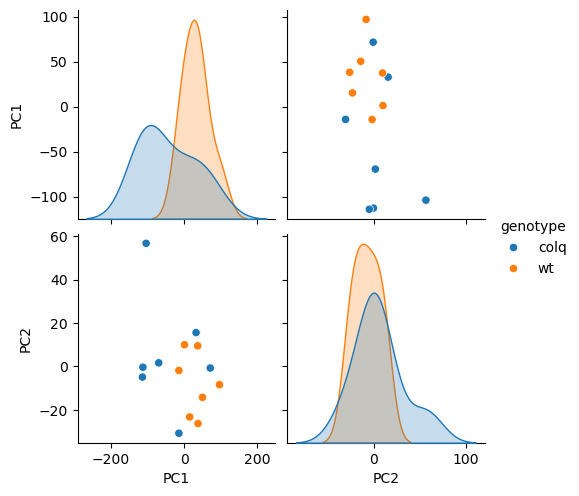

In [19]:
pcs =  mpca.transform(bps.squeeze())
lst = []
for i,filename in enumerate(filenames): 
    tlst = [filename,mapping_dct[filename],*pcs[i].tolist()]
    lst.append(tlst)
pdf = pd.DataFrame(lst,columns=["filename","mouse_id",*[f"PC{i+1}" for i in range(n_comp)]])
pdf["genotype"] = pdf["mouse_id"].apply(lambda x : x[:-2])
pdf.dtypes
p = sns.pairplot(pdf,hue = "genotype",vars=[f"PC{i+1}" for i in range(n_comp)])

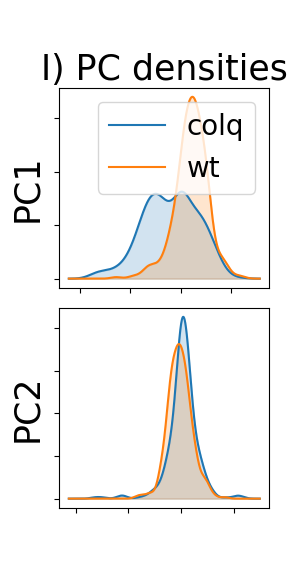

In [22]:
color_mapping ={"colq": "tab:blue", "wt" : "tab:orange"}
components = [f"PC{i+1}" for i in range(n_comp)]
span =0.3
nsample = 10000
ft_size = 25
pft_size = 20



fig,axs = plt.subplots(nrows=n_comp,ncols=1, figsize = (3,n_comp*3))
for i,comp in enumerate(components): 
    r = df[comp].values.max()
    l = df[comp].values.min()
    x = np.linspace(l -np.abs(span*l),r +np.abs(span*r),nsample)
    for gen,color in color_mapping.items(): 
        arr = df[df.genotype == gen][comp].values
        y = gaussian_kde(arr)(x)
        axs[i].plot(x,y,color=color,label=gen)
        axs[i].fill_between(x,y,color=color,alpha=0.2)
        axs[i].set_ylabel(comp,fontsize=ft_size)


for ax in axs: 
    ax.set_yticklabels([])
    ax.set_xticklabels([])
axs[0].legend(fontsize=pft_size)
axs[0].set_title("I) PC densities",fontsize=ft_size)
axs[-1].set_xlabel(" ",fontsize=pft_size)
fig.suptitle(" ",fontsize=ft_size)


plt.subplots_adjust(left=0.2,bottom=0.15,right=0.9,top=0.85,wspace=0.1,hspace=0.1)
fig.savefig("./figures/ts-lddmm_exp_1_density.jpeg",format="jpeg")

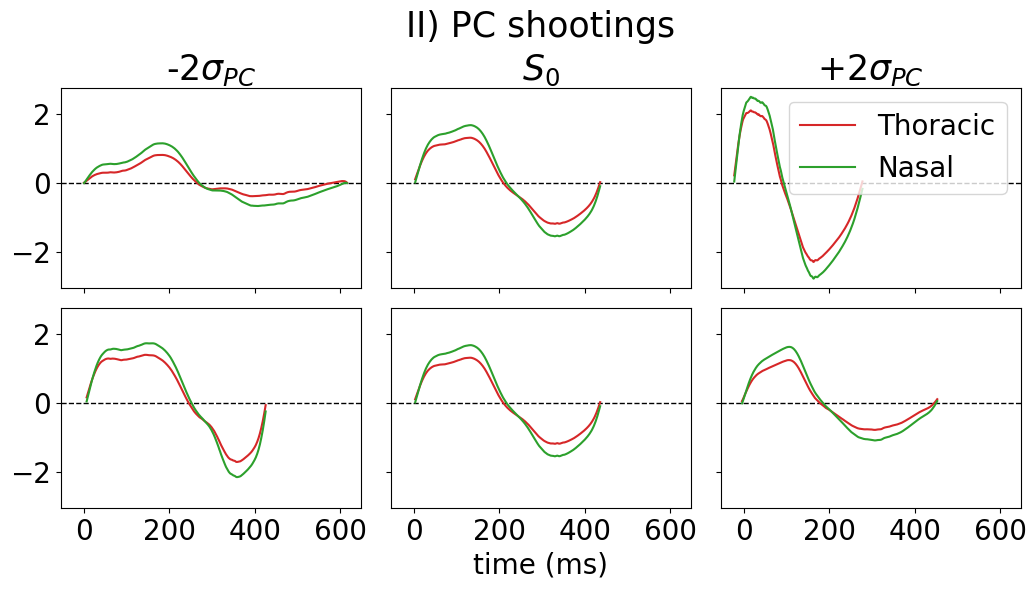

In [23]:
from src.statistic import MomentaPCA
ncomp,ndisp = 2,3
mpca = MomentaPCA(ncomp)
mpca.fit(Kv,p0s,q0,q0_mask)

p0_bar = mpca.m_ps_
k = 1

fig,axs = plt.subplots(ncomp,ndisp,figsize = (ndisp*4,ncomp*3),sharex=True,sharey=True)
for pca_index in range(ncomp):
    sigma_pca = np.std(mpca.p_score_[:,pca_index])
    for j,alpha in enumerate(np.linspace(-2*sigma_pca , 2*sigma_pca, ndisp)):
        p0_mode = p0_bar + alpha * mpca.p_pc_[pca_index]
        p,q = shoot(p0_mode,q0,q0_mask)
        q = q[q0_mask.squeeze()]
        axs[pca_index,j].plot(q[:,0],q[:,1],color="tab:red",label="Thoracic")
        axs[pca_index,j].plot(q[:,0],q[:,2],color="tab:green",label="Nasal")
        k += 1

for ax in axs.flatten():
    ax.axhline(0,color="black",linewidth=1,linestyle="--",zorder=0)

axs[-1,1].set_xlabel("time (ms)",fontsize=pft_size)

axs[0,0].set_title(r"-2$\sigma_{PC}$",fontsize=ft_size)
axs[0,1].set_title(r"$S_0$",fontsize=ft_size)
axs[0,2].set_title(r"+2$\sigma_{PC}$",fontsize=ft_size)
axs[0,2].legend(fontsize = pft_size,loc=1)
for ax in axs[-1,:]:
    ax.xaxis.set_tick_params(labelsize=pft_size)
for ax in axs[:,0]:
    ax.yaxis.set_tick_params(labelsize=pft_size)

fig.suptitle("II) PC shootings",fontsize = ft_size)

plt.subplots_adjust(left=0.1,bottom=0.15,right=0.9,top=0.85,wspace=0.1,hspace=0.1)
fig.savefig("./figures/ts-lddmm_exp_1_shooting.jpeg",format="jpeg")


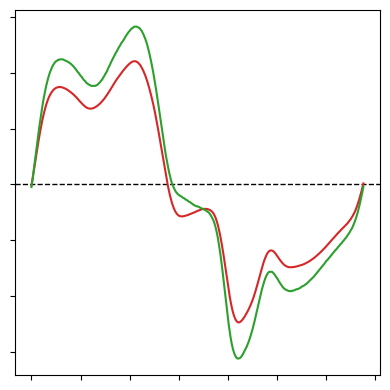

In [24]:
fig,ax = plt.subplots(nrows=1,ncols=1, figsize = (4,4))

idxs = np.argsort(df.PC1.values)
idx = idxs[10]
q = X[idx]
q_mask = X_mask[idx]
q = q[q_mask.squeeze()]
ax.plot(q[:,0],q[:,1],color="tab:red",label="Thoracic")
ax.plot(q[:,0],q[:,2],color="tab:green",label="Nasal")
ax.axhline(0,color="black",linewidth=1,linestyle="--",zorder=0)

ax.set_xticklabels([])
ax.set_yticklabels([])
fig.tight_layout()

fig.savefig("./figures/ts-lddmm_exp_1_cycle_example.jpeg",format="jpeg")

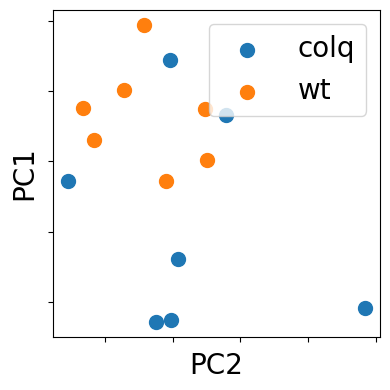

In [25]:
fig,ax = plt.subplots(nrows=1,ncols=1, figsize = (4,4))

c = pdf[pdf.genotype == "colq"][["PC2","PC1"]].values
ax.scatter(*c.T,color=color_mapping["colq"],label="colq",s=100)
w = pdf[pdf.genotype == "wt"][["PC2","PC1"]].values
ax.scatter(*w.T,color = color_mapping["wt"],label="wt",s = 100)
ax.set_xlabel("PC2", fontsize=pft_size)
ax.set_ylabel("PC1", fontsize=pft_size)
ax.legend(fontsize=20,loc=1)

ax.set_xticklabels([])
ax.set_yticklabels([])
fig.tight_layout()
fig.savefig("./figures/ts-lddmm_exp_1_scatter.jpeg",format="jpeg")